In [ ]:
import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.layers import Lambda
from fastai.callbacks import *
import pytorch_ssim as ssim
from superres import *
from torchvision.models import vgg16_bn
import czifile
import shutil

In [2]:
path_combo_src_hr = Path('/DATA/WAMRI/salk/uri/combo_src/')
path_combo_src_lr = Path('/DATA/WAMRI/salk/uri/combo_lr_pair/')
path_combo_hr = Path('/DATA/WAMRI/salk/uri/combo_hr/')
path_combo_lr = Path('/DATA/WAMRI/salk/uri/combo_lr/')
path_test_lr = Path('/DATA/WAMRI/salk/uri/test_imgs/')

In [3]:
def pull_id(fn):
    return fn.split('#')[-1].split('.')[0]

pair_names_by_id = {pull_id(lrfn.name):lrfn for lrfn in path_combo_src_lr.glob('*.tif')}

def match_lr_fn(x):
    return pair_names_by_id[pull_id(x.name)]

def get_czi_shape_info(czi):
    shape = czi.shape
    axes = czi.axes
    axes_dict = {axis:idx for idx,axis in enumerate(czi.axes)}
    shape_dict = {axis:shape[axes_dict[axis]] for axis in czi.axes}
    return axes_dict, shape_dict


def build_index(axes, ix_select):
    idx = [ix_select.get(ax, 0) for ax in axes]
    return tuple(idx)

def process_tiff(fn):
    lr_match = match_lr_fn(fn)
    shutil.copy(fn, path_combo_hr/fn.name)
    shutil.copy(lr_match, path_combo_lr/fn.name)
    

def process_czi(proc_fn):
    with czifile.CziFile(proc_fn) as proc_czf:
        proc_axes, proc_shape = get_czi_shape_info(proc_czf)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        x,y = proc_shape['X'], proc_shape['Y']
        data = proc_czf.asarray()
        for channel in range(channels):
            depth = depths // 2
            idx = build_index(proc_axes, {'C': channel, 'Z':depth, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx].astype(np.float)
            save_proc_fn = path_combo_hr/f'{proc_fn.stem}_{channel:02d}_{depth:03d}.tif'
            img /= img.max()
            pimg = PIL.Image.fromarray(img)
            pimg.save(save_proc_fn)
            cur_size = pimg.size
            new_size = (cur_size[0]//4, cur_size[1]//4)
            pimg.resize(new_size, resample=PIL.Image.BICUBIC).save(path_combo_lr/save_proc_fn.name)
    
def process_src(fn):
    if fn.suffix == '.tif':
        process_tiff(fn)
        pass
    elif fn.suffix == '.czi':
        process_czi(fn)

fnames = list(path_combo_src_hr.iterdir())

In [4]:
# print(len(fnames))
# for fn in progress_bar(fnames):
#     process_src(fn)

In [5]:
def get_basename(x):
    return x.name

base_names = list(set([get_basename(x) for x in list(path_combo_lr.iterdir())]))
train_names, valid_names = random_split(0.15, base_names)
valid_names = list(valid_names[0])

def is_validation_basename(x):
    return x.name in valid_names

def lr_to_hr_fn(x):
    return path_combo_hr/x.name

In [6]:
src = (GrayImageItemList
       .from_folder(path_combo_lr, '*.tif', label_class=GrayImageItemList)
       .split_by_valid_func(is_validation_basename)
       .label_from_func(lr_to_hr_fn))

In [7]:
def charbonnier_loss(inputs, targets):
    eps = 1e-6;
    d = inputs - targets
    e = torch.sqrt(d**2 + eps)
    return e.mean()



In [8]:
loss = charbonnier_loss
loss = F.mse_loss
scale=4
n_resblocks=16
n_feats=64
res_scale= 0.1
#model = WDSR(scale, n_resblocks, n_feats, res_scale, n_colors_in=1)
model = DBPNLL(num_channels=1, base_filter=64, feat = 256, num_stages=10, scale_factor=scale)
model = nn.DataParallel(model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


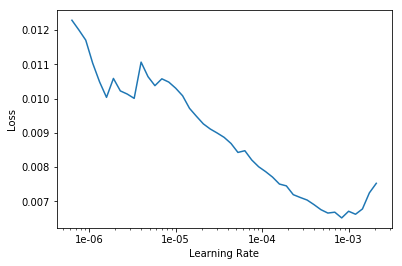

In [9]:
sz_lr = 128
scale,bs = 4,4
sz_hr = sz_lr*scale

learn = build_learner(model, bs, sz_lr, sz_hr, src, loss=loss) #, callback_fns=LossMetrics)
learn.lr_find()
learn.recorder.plot()

In [ ]:
sz_lr = 128
scale,bs = 4,4
sz_hr = sz_lr*scale

epochs, lr = 10, 1e-4
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, save='DBPNLL_1.0', loss=loss)

epoch,train_loss,valid_loss,mse_loss,ssim,psnr
1,0.004281,0.004183,0.004183,0.601690,25.408817
2,0.004040,0.004071,0.004071,0.786758,26.322565


In [ ]:
sz_lr = 128
scale,bs = 4,16
sz_hr = sz_lr*scale

epochs, lr = 10, 2e-4
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, load='combo_1.0_best', save='combo_1.1', loss=loss)

In [ ]:
scale,bs = 4,1
sz_hr = sz_lr*scale
data = get_data(src, bs, sz_lr, sz_hr)
learn = Learner(data, model, loss_func=F.mse_loss).load('combo_1.1')
preds, ys = learn.get_preds(DatasetType.Valid)
preds = torch.clamp(preds, 0.,1.)



In [ ]:
idx = 2
hr = Image(ys[idx])
hr

In [ ]:
sr = Image(preds[idx])
sr

In [ ]:
lr = learn.data.valid_ds[idx][0]
data = lr.data.permute([1,2,0]).repeat([1,1,3]).detach().cpu().numpy()
img = PIL.Image.fromarray((data * 255).astype(np.uint8))
data = pil2tensor(img.resize((2024,2024), resample=PIL.Image.BICUBIC), dtype=np.float32)
lr = Image(data[0:1,:,:])
lr

In [ ]:
img1, img2 = sr.data[None],hr.data[None]
ssim.ssim(img1,img2), psnr(img1,img2), F.mse_loss(img1,img2)

In [ ]:
img1, img2 = lr.data[None], hr.data[None]
ssim.ssim(img1,img2), psnr(img1,img2), F.mse_loss(img1,img2)

In [ ]:
fake_label = list(path_combo_hr.iterdir())[0]
test_src = src.add_test_folder(path_test_lr, label=fake_label)

In [ ]:
sz_lr = 506
scale,bs = 4,1
sz_hr = sz_lr*scale
data = get_data(src, bs, sz_lr, sz_hr)
learn = Learner(data, model, loss_func=F.mse_loss).load('combo_1.0_best')
preds, ys = learn.get_preds(DatasetType.Test)
preds = torch.clamp(preds, 0.,1.)


In [ ]:
idx=2
sr = Image(preds[idx])
sr

In [ ]:
lr = learn.data.test_ds[idx][0]
data = lr.data.permute([1,2,0]).repeat([1,1,3]).detach().cpu().numpy()
img = PIL.Image.fromarray((data * 255).astype(np.uint8))
data = pil2tensor(img.resize((2024,2024), resample=PIL.Image.BICUBIC), dtype=np.float32)
lr = Image(data[0:1,:,:])
lr

In [ ]:
test_fns

In [ ]:
def my_pred(self, item:ItemBase, **kwargs):
    self.callbacks.append(RecordOnCPU())
    batch = self.data.one_item(item)
    batch = to_half(batch)
    res = self.pred_batch(batch=batch)
    pred = res[0]
    x = self.callbacks[-1].input
    x = x.float()
    pred = pred.float()
    norm = getattr(self.data,'norm',False)
    if norm:
        x = self.data.denorm(x)
        if norm.keywords.get('do_y',False): pred = self.data.denorm(pred)
    self.callbacks = self.callbacks[:-1]
    ds = self.data.single_ds
    pred = ds.y.analyze_pred(pred, **kwargs)
    out = ds.y.reconstruct(pred, ds.x.reconstruct(x[0])) if has_arg(ds.y.reconstruct, 'x') else ds.y.reconstruct(pred)
    return out, pred, res[0]

In [ ]:
# loss = charbonnier_loss
# scale=4
# n_resblocks=128
# n_feats=32
# res_scale= 0.1
# model = WDSR(scale, n_resblocks, n_feats, res_scale, n_colors_in=1)

scale = 4
test_fns = list(path_test_lr.iterdir())
for fn in test_fns:
    learn = None
    gc.collect()
    img = open_grayscale(fn)
    
    scale,bs = 4,1
    sz_lr = max(img.shape)
    sz_lr = int(sz_lr)
    sz_hr = sz_lr*scale
    print(sz_lr, sz_hr)
    data = get_data(src, bs, sz_lr, sz_hr)
    learn = Learner(data, model, loss_func=F.mse_loss).to_fp16().load('combo_1.0_best')
    a,b,c = my_pred(learn, img)
    img_big = Image(a.data[0:1,:,:])
    lr_fn = Path(fn.stem + '_LR.png')
    img.save(lr_fn)
    hr_fn = Path(fn.stem + '_HR.png')
    img_big.save(hr_fn)
    print(lr_fn, hr_fn)

In [ ]:
img_big

In [ ]:
img

In [ ]:
sz_lr = 128
scale,bs = 4,1
sz_hr = sz_lr*scale
data = get_data(src, bs, sz_lr, sz_hr)


In [ ]:
b = data.one_batch()

In [ ]:
b[0].shape

In [ ]:
model = model.eval().cuda()

In [ ]:
bc = b[0].to(0)
bc.shape

In [ ]:
model(bc).shape

In [ ]:
%debug